In [1]:
import mne
import numpy as np
import pickle
import yaml
import matplotlib.pyplot as plt
import os


from gait_modulation import FeatureExtractor, DataProcessor
from gait_modulation.utils.utils import split_data, load_config

In [2]:
with open('processed/all_lfp_data.pkl', 'rb') as f:
    all_lfp_data = pickle.load(f)
    
with open('gait_modulation/configs/data_preprocessing.yaml', 'r') as file:
    config = yaml.safe_load(file)

# 1. Time domain

## 1.1. continuous data

### Feature 1: Time domain representation of continuous data

In [3]:
# pad or truncate
# all_lfp_data should be a list of arrays, each of shape (n_channels, time)
all_lfp_uniform_size = DataProcessor.pad_or_truncate(all_lfp_data, config)

In [4]:
np.savez('processed/features/time_continuous_uniform-feat.npz',
         times_uniform=all_lfp_uniform_size)
all_lfp_uniform_size.shape

(16, 6, 38213)

In [5]:
# import matplotlib.pyplot as plt
# # plt.plot(processed_trials[0][0])
# # plt.plot(processed_trials[0][1])
# # plt.plot(processed_trials[0][2])
# # plt.plot(processed_trials[0][3])
# plt.plot(processed_trials[2][4])
# # plt.plot(processed_trials[0][5])

### Feature 2: Time domain representation of continuous data - combine channels * times

In [6]:
n_trials = all_lfp_uniform_size.shape[0]
n_channels = all_lfp_uniform_size.shape[1]
n_samples = all_lfp_uniform_size.shape[2]

lfp_data_combined_ch_time = all_lfp_uniform_size.reshape((
    n_trials, n_channels*n_samples))

In [7]:
np.savez('processed/features/time_continuous_uniform_combined_ch_time-feat.npz',
         lfp_data_combined_ch_time=lfp_data_combined_ch_time)
lfp_data_combined_ch_time.shape

(16, 229278)

### Features 3: Summary Statistics on continuous data in the time domain

In [8]:
time_domain_stats_feat = {
    'trials_stat': {
        'mean': np.mean(all_lfp_uniform_size, axis=0),
        'std': np.std(all_lfp_uniform_size, axis=0),
        'median': np.median(all_lfp_uniform_size, axis=0)
    },
    'channels_stat': {
        'mean': np.mean(all_lfp_uniform_size, axis=1),
        'std': np.std(all_lfp_uniform_size, axis=1),
        'median': np.median(all_lfp_uniform_size, axis=1)
    },
    'times_stat': {
        'mean': np.mean(all_lfp_uniform_size, axis=2),
        'std': np.std(all_lfp_uniform_size, axis=2),
        'median': np.median(all_lfp_uniform_size, axis=2)
    }
}

In [9]:
np.savez('processed/features/time_continuous_stats-feat.npz', 
         time_domain_stats_feat=time_domain_stats_feat)
time_domain_stats_feat['trials_stat']['mean'].shape

# Check the shape of each feature in the dictionary
for agg_method, features in time_domain_stats_feat.items():
    for feat_name, feat_values in features.items():
        print(f"Avergave by: {agg_method}, feature: {feat_name}, shape: {feat_values.shape}")

Avergave by: trials_stat, feature: mean, shape: (6, 38213)
Avergave by: trials_stat, feature: std, shape: (6, 38213)
Avergave by: trials_stat, feature: median, shape: (6, 38213)
Avergave by: channels_stat, feature: mean, shape: (16, 38213)
Avergave by: channels_stat, feature: std, shape: (16, 38213)
Avergave by: channels_stat, feature: median, shape: (16, 38213)
Avergave by: times_stat, feature: mean, shape: (16, 6)
Avergave by: times_stat, feature: std, shape: (16, 6)
Avergave by: times_stat, feature: median, shape: (16, 6)


## 1.2. Fixed-size sliding windows

### Features 4: Summary Statistics on fixed windows in the time domain

In [10]:
time_windowed_stat_feat = FeatureExtractor.extract_windowed_stat_features(
    all_lfp_uniform_size,
    methods=['mean', 'std', 'median'],
    window_size=100, step_size=50, verbose=False)

# Check the shape of each feature in the dictionary
for method, features in time_windowed_stat_feat.items():
    print(f"{method} features shape:", features.shape)

np.savez('processed/features/time_windowed_stat-feat.npz', 
         time_windowed_stat_feat=time_windowed_stat_feat)
all_lfp_uniform_size.shape

mean features shape: (16, 6, 763)
std features shape: (16, 6, 763)
median features shape: (16, 6, 763)


(16, 6, 38213)

## Feature 5: Time domain representation of epochs

In [11]:
epochs = mne.read_epochs('processed/lfp_-3.0tmin_5gap-epo.fif')
time_epoched = epochs.get_data(copy=False)

Reading /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/gait_modulation/processed/lfp_-3.0tmin_5gap-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...       0.00 ms
        0 CTF compensation matrices available
Not setting metadata
891 matching events found
No baseline correction applied
0 projection items activated


In [12]:
np.savez('processed/features/time_epoched-feat.npz', 
         time_epoched=time_epoched)
time_epoched.shape

(891, 6, 751)

## Feature 6: Time domain representation of epochs - Summary Statistics

In [13]:
time_epoched_stat_feat = FeatureExtractor.extract_epoched_stat_features(
    epochs=epochs, methods=['mean', 'std', 'median'])

np.savez('processed/features/time_epoched_stat-feat.npz', 
         time_epoched_stat_feat=time_epoched_stat_feat)

for agg_method, features in time_epoched_stat_feat.items():
    for feat_name, feat_values in features.items():
        print(f"Avergave by: {agg_method}, feature: {feat_name}, shape: {feat_values.shape}")

UnboundLocalError: local variable 'np' referenced before assignment

# 2. Frequency domain

## Feature 1: Frequency domain representation of epoched data

In [14]:
freq_bands = {
    'delta': (0.1, 3),
    'theta': (4, 7),
    'alpha': (8, 12),
    'low_beta': (12, 16),
    'middle_beta': (16, 20),
    'high_beta': (20, 30),
    'gamma': (30, 100),
    'high_gamma': (100, 125)
}

In [15]:
# %matplotlib qt
# montage.plot(kind='3d')
# plt.show()

In [16]:
# %matplotlib qt

# # Average the epochs for each event type
# mod_start_evoked = epochs['mod_start'].average()
# normal_walking_evoked = epochs['normal_walking'].average()

# # Plot the averaged epochs with titles and spatial colors
# fig_mod_start = mod_start_evoked.plot(titles='mod_start', spatial_colors=False)
# fig_normal_walking = normal_walking_evoked.plot(titles='Normal Walking', spatial_colors=False)

# # Save the plots to files
# fig_mod_start.savefig('images/mod_start_evoked_plot.png')
# fig_normal_walking.savefig('images/normal_walking_evoked_plot.png')

Using matplotlib as 2D backend.


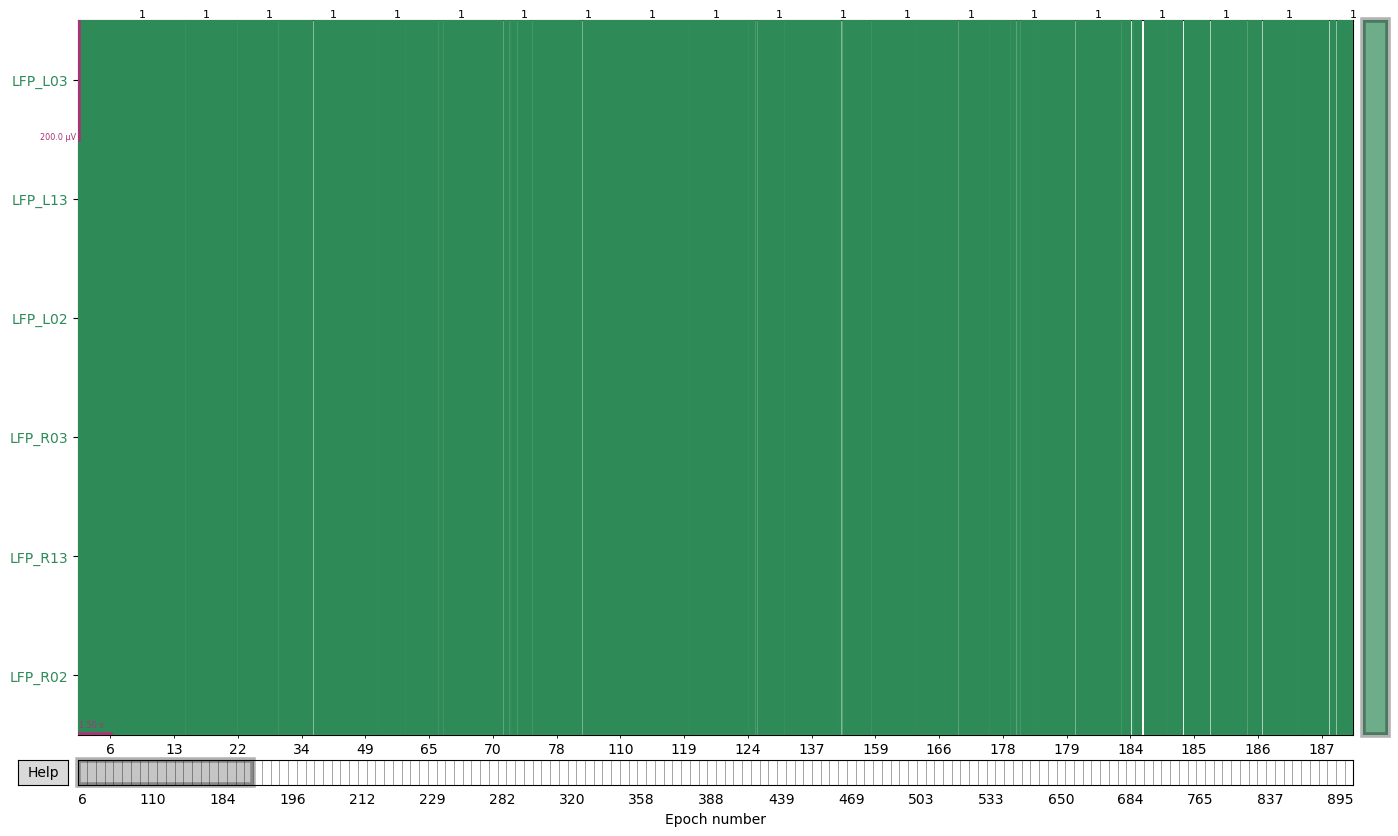

Not setting metadata
146 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


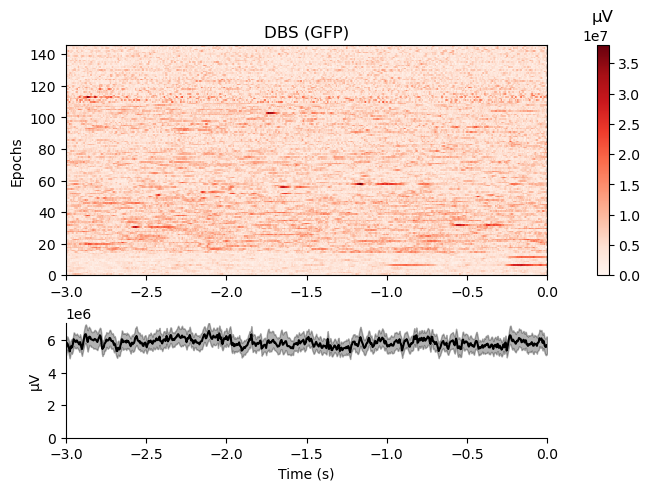

In [17]:
# %matplotlib widget
# %matplotlib qt
%matplotlib inline
# %matplotlib notebook
epochs['mod_start'].plot(events=True, block=False)
# epochs['normal_walking'].plot(events=True, block=False)
fig = epochs['mod_start'].plot_image(combine=None)
fig[0].savefig('images/mod_start_LFP_allChs.png')

In [18]:
# # %matplotlib widget
# sfreq = epochs.info['sfreq']
# freqs = np.arange(0.1, 60, 0.1)
# n_cycles = freqs / 2

# epochs_mod_start = epochs['mod_start']
# epochs_normal_walking = epochs['normal_walking']

# power_mod_start = epochs_mod_start.compute_tfr(
#     method="multitaper", freqs=freqs, n_cycles=n_cycles)

# power_normal_walking = epochs_normal_walking.compute_tfr(
#     method="multitaper", freqs=freqs, n_cycles=n_cycles)

In [19]:
sfreq = epochs.info['sfreq']
freqs = np.arange(0.1, 60, 1) # Reduce Frequency Resolution for faster computation
n_cycles = freqs / 2

power = epochs.compute_tfr(
    method="multitaper", freqs=freqs, n_cycles=n_cycles, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    9.8s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   11.4s finished


In [20]:
power.save('processed/features/epochs_power-tfr.h5', overwrite=True)

Overwriting existing file.


In [21]:
power = mne.time_frequency.read_tfrs('processed/features/epochs_power-tfr.h5')
power.shape

Reading /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/gait_modulation/processed/features/epochs_power-tfr.h5 ...


(891, 6, 60, 751)

In [22]:
# Load the power data from the saved file

mod_start_event_id = config['events']['mod_start_event_id']
normal_walking_event_id = config['events']['normal_walking_event_id']

mod_start_idx = np.where(epochs.events[:, -1] == mod_start_event_id)[0]
normal_walking_idx = np.where(epochs.events[:, -1] == normal_walking_event_id)[0]

power_mod_start = power[mod_start_idx]
power_normal_walking = power[normal_walking_idx]

In [ ]:
def save_tfr_plots(power, output_folder='images/tfr_epochs', subplot_width=4, subplot_height=3):
    """
    Save TFR plots for each epoch and each channel, organized in a grid where columns are epochs and rows are channels.

    Parameters:
    power : mne.time_frequency.EpochsTFR
        The TFR power object.
    output_folder : str
        The folder where the plots will be saved.
    subplot_width : int
        Width of each subplot in inches.
    subplot_height : int
        Height of each subplot in inches.
    """
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Number of epochs and channels
    n_epochs = power.shape[0]
    n_channels = len(power.ch_names)

    # Create a figure with subplots
    fig, axes = plt.subplots(n_channels, n_epochs, figsize=(n_epochs * subplot_width, n_channels * subplot_height), sharex=True, sharey=True)

    # Loop through each epoch and each channel to create subplots
    for epoch_idx in range(n_epochs):
        print(epoch_idx)
        for ch_idx, ch_name in enumerate(power.ch_names):
            ax = axes[ch_idx, epoch_idx]
            power[epoch_idx].plot(picks=[ch_idx], axes=ax, colorbar=False, show=False)
            ax.set_xlabel(f'Patient {power.events[epoch_idx, 1]}')  # mark the patient idx
            ax.set_ylabel('')  # Hide y-axis title
            if epoch_idx == 0:
                ax.set_ylabel(ch_name)  # Show channel name on the y-axis for the first column
            if ch_idx == 0:
                ax.set_title(f'Epoch {epoch_idx + 1}')  # Show epoch number on the x-axis for the first row

    # Add super titles for x and y axes
    fig.suptitle('TFR for All Epochs and Channels', fontsize=16)
    fig.supxlabel('Time (s)', fontsize=14)
    fig.supylabel('Frequency (Hz)', fontsize=14)

    # Adjust layout
    plt.tight_layout()

    # Save the figure to the folder
    fig.savefig(os.path.join(output_folder, 'tfr_all_epochs.png'))

    # Show the plot
    plt.show()

# Save TFR plots for mod_start event
save_tfr_plots(power_mod_start, output_folder='images/tfr_epochs/tfr_epochs_mod_start')

# Save TFR plots for normal_walking event
# save_tfr_plots(power_normal_walking, output_folder='images/tfr_normal_walking')

0
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
1
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
2
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
3
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
4
No baseline correction applied
No baseline correction applied
No baseline correction applied


KeyboardInterrupt: 

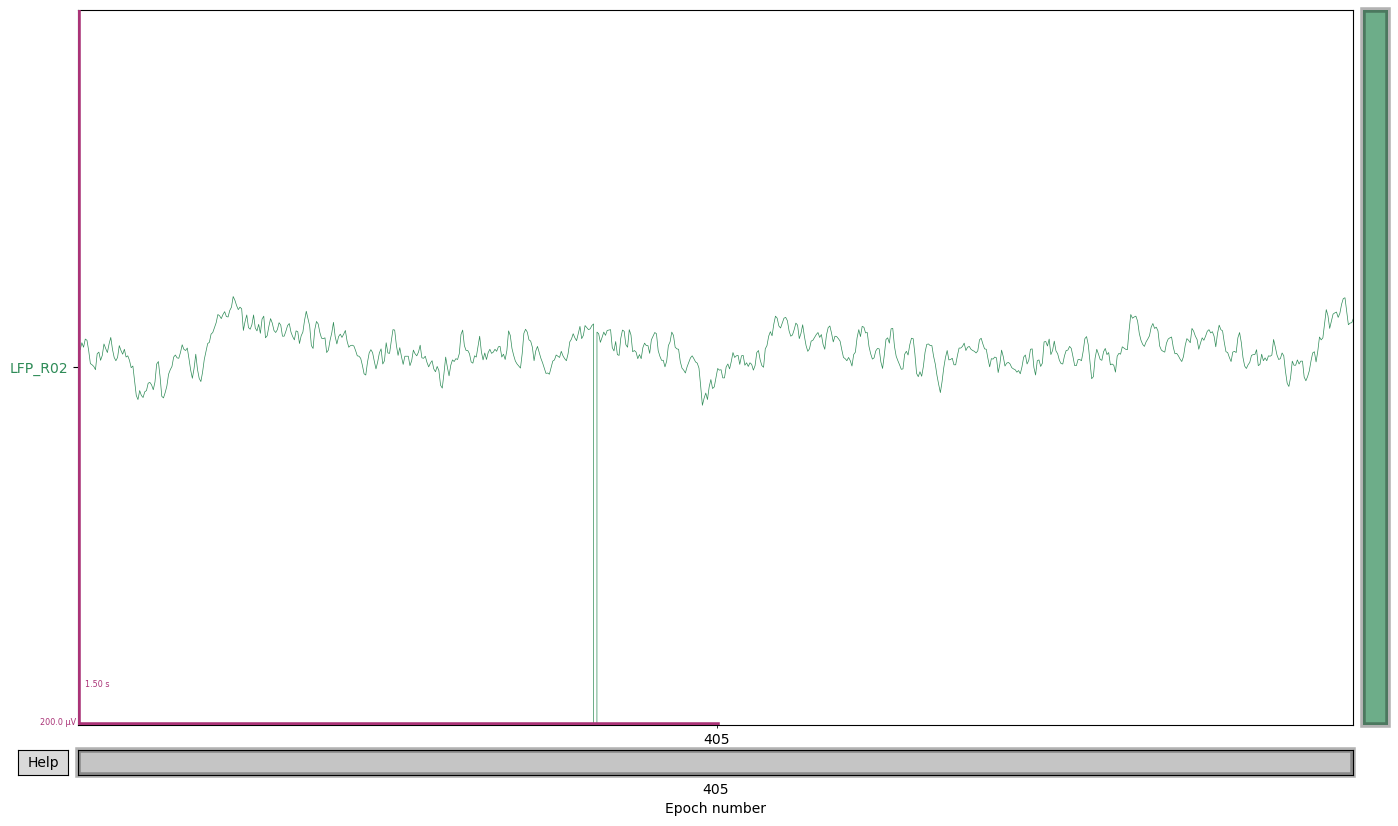

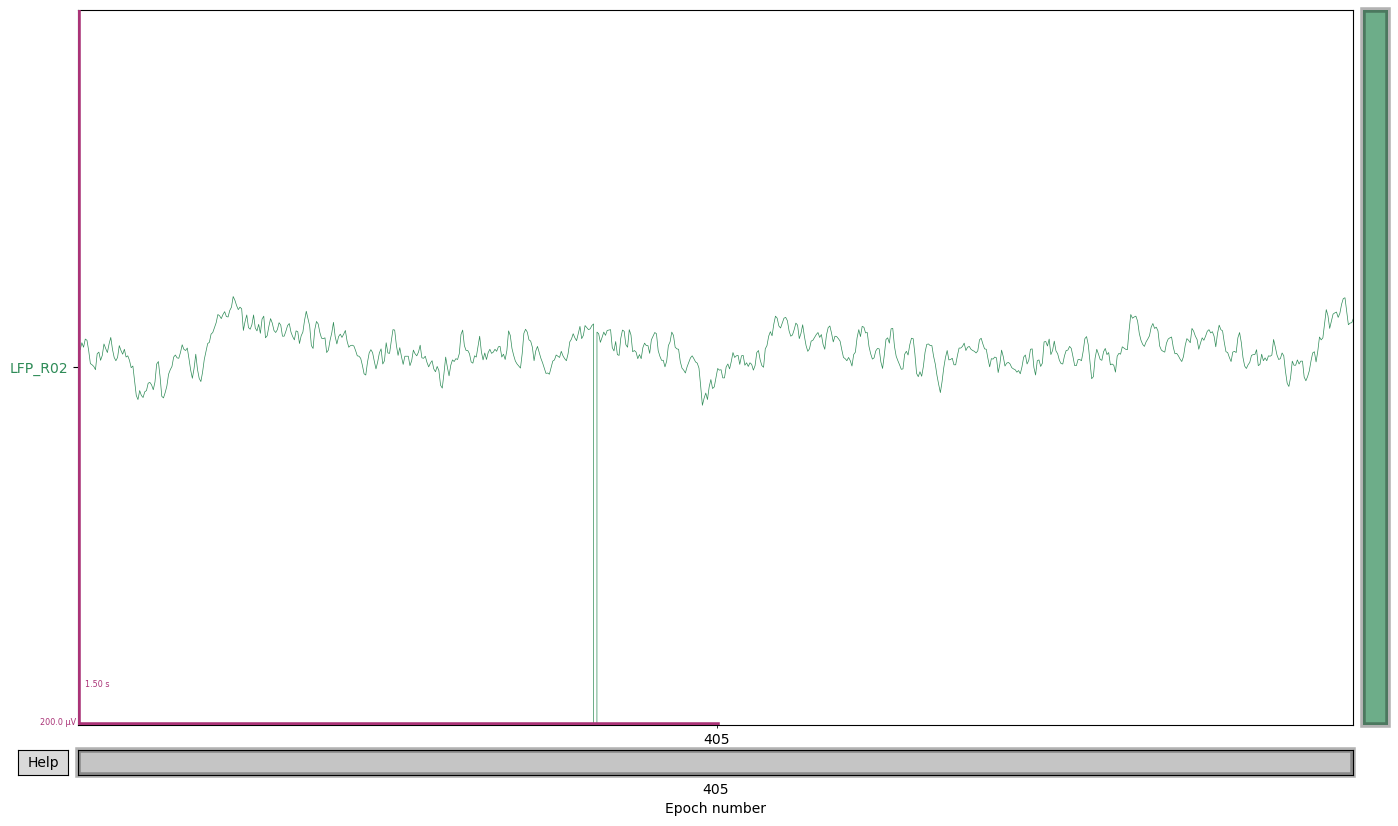

In [ ]:
epochs['mod_start'][76].plot(picks=[5])

In [ ]:
power_mod_start.get_data()[76, 5].shape

(60, 751)

In [ ]:
reject_criteria = dict(dbs=150e-6)
e = epochs['normal_walking'].copy().drop_bad(reject=reject_criteria)
e_power = e.compute_tfr(
    method="multitaper", freqs=freqs, n_cycles=n_cycles)

e.get_data().shape

    Rejecting  epoch based on DBS : ['LFP_L03']
1 bad epochs dropped


/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_4530/129064898.py:6: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  e.get_data().shape


(745, 6, 751)

In [ ]:
e_power

Data type,Power Estimates
Data source,Epochs
Number of epochs,146
Dims,"epoch, channel, freq, time"
Estimation method,multitaper
Number of channels,6
Number of timepoints,751
Number of frequency bins,59
Frequency range,1.00 – 59.00 Hz


No baseline correction applied


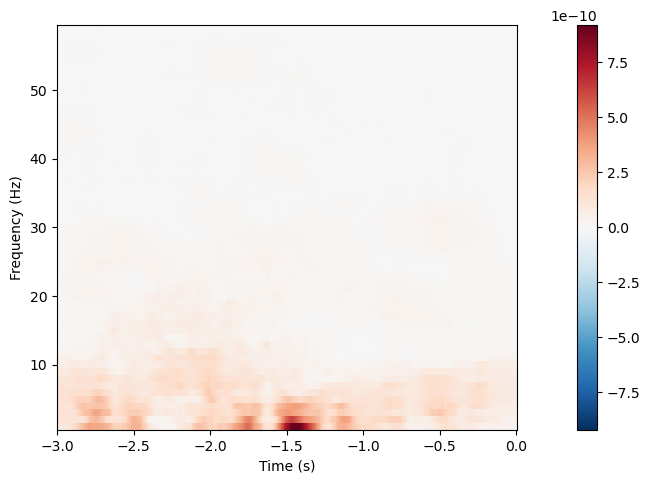

[<Figure size 640x480 with 2 Axes>]

In [ ]:
e_power[76].plot(picks=[5], show=True)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

def save_tfr_plots(power, output_folder='images/tfr_epochs', subplot_width=4, subplot_height=3):
    """
    Save TFR plots for each epoch and each channel, organized in a grid where columns are epochs and rows are channels.

    Parameters:
    power : mne.time_frequency.EpochsTFR
        The TFR power object.
    output_folder : str
        The folder where the plots will be saved.
    subplot_width : int
        Width of each subplot in inches.
    subplot_height : int
        Height of each subplot in inches.
    """
    # Number of epochs and channels
    n_epochs = power.shape[0]
    n_channels = len(power.ch_names)

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Loop through each epoch and create a figure with 6 subplots
    for epoch_idx in range(n_epochs):
        print(f'Plotting TFR for Epoch {epoch_idx + 1}')
        fig, axes = plt.subplots(n_channels, 1, figsize=(subplot_width, n_channels * subplot_height), sharex=True, sharey=True)
        
        for ch_idx, ch_name in enumerate(power.ch_names):
            ax = axes[ch_idx]
            power[epoch_idx].plot(picks=[ch_idx], axes=ax, colorbar=False, show=False, title=f'{ch_name}')
            ax.set_xlabel(f'Patient {power.events[epoch_idx, 1]}')  # mark the patient idx
            ax.set_ylabel('')  # Hide y-axis title
        
        # Add super titles for x and y axes
        fig.suptitle(f'TFR for Epoch {epoch_idx + 1}', fontsize=16)
        fig.supxlabel('Time (s)', fontsize=14)
        fig.supylabel('Frequency (Hz)', fontsize=14)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save the figure to the folder
        fig.savefig(os.path.join(output_folder,
                                 f'tfr_epoch_{epoch_idx + 1}_patient_{power.events[epoch_idx, 1]}.png'))
        
        # Close the figure to free up memory
        plt.close(fig)

# Example usage
save_tfr_plots(power_mod_start, output_folder='images/tfr_epochs_mod_start')

Plotting TFR for Epoch 1
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
Plotting TFR for Epoch 2
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
Plotting TFR for Epoch 3
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
Plotting TFR for Epoch 4
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
Plotting TFR for Epoch 5
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No base

In [ ]:
baseline = epochs.tmin, epochs.tmax

In [ ]:
%matplotlib qt

avg_power = power.average()
avg_power.plot(baseline=baseline, title='Mod Start Power')

In [ ]:

# Plot the averaged power for each channel with the channel name in the title
for ch_idx, ch_name in enumerate(avg_power.ch_names):
    avg_power.plot(picks=[ch_idx], baseline=baseline, title=f'Mod Start Power - {ch_name}')

In [ ]:
# Exrtact spectral features for both classes at once
psds, freqs, band_power = FeatureExtractor.extract_psd_and_band_power(
    epochs,
    freq_bands,
    fmin=min([f[0] for f in freq_bands.values()]),
    fmax=max([f[1] for f in freq_bands.values()])
)
np.savez_compressed('processed/features/psd_bandPower-feat.npz', 
                    psds=psds, 
                    band_power=band_power)

print(freqs.shape)
print(psds.shape)  
print(band_power.shape)

In [ ]:
# # mod_start features
# spectral_feat_mod_start = FeatureExtractor.extract_psd_and_band_power(
#     epochs['mod_start'],
#     freq_bands,
#     fmin=min([f[0] for f in freq_bands.values()]),
#     fmax=max([f[1] for f in freq_bands.values()])
# )
# psds_mod_start, freqs_mod_start, band_power_mod_start = spectral_feat_mod_start

# np.savez_compressed('processed/features/spectral_feat_mod_start.npz', 
#                     psds_mod_start=psds_mod_start, 
#                     band_power_mod_start=band_power_mod_start)

# print(freqs_mod_start.shape)
# print(psds_mod_start.shape)  
# print(band_power_mod_start.shape)

In [ ]:
# # normal_walking features
# spectral_feat_normal_walking = FeatureExtractor.extract_psd_and_band_power(
#     epochs['normal_walking'],
#     freq_bands,
#     fmin=min([f[0] for f in freq_bands.values()]),
#     fmax=max([f[1] for f in freq_bands.values()])
# )

# psds_normal_walking, freqs_normal_walking, band_power_normal_walking = spectral_feat_normal_walking

# np.savez_compressed('processed/features/spectral_feat_normal_walking.npz', 
#                     psds_normal_walking=psds_normal_walking, 
#                     band_power_normal_walking=band_power_normal_walking)

# print(freqs_normal_walking.shape)
# print(psds_normal_walking.shape)  
# print(band_power_normal_walking.shape)

In [ ]:
# psds_bandPower_mod_start = np.concatenate((psds_mod_start,
#                                            band_power_mod_start), axis=2)

# psds_bandPower_normal_walking = np.concatenate((psds_normal_walking, 
#                                                 band_power_normal_walking), axis=2)

# psds_bandPower_both_classes = np.concatenate((psds_bandPower_mod_start,
#                                               psds_bandPower_normal_walking), axis=0)
# # Generate labels
# labels = np.concatenate((np.ones(psds_bandPower_mod_start.shape[0]),
#                          -np.ones(psds_bandPower_normal_walking.shape[0])), axis=0)

# print(psds_mod_start.shape, band_power_mod_start.shape, psds_bandPower_mod_start.shape)
# print(psds_normal_walking.shape, band_power_normal_walking.shape, psds_bandPower_normal_walking.shape)

# print(psds_bandPower_both_classes.shape, labels.shape)
# psds_bandPower_both_classes.reshape(psds_bandPower_both_classes.shape[0], -1).shape

In [ ]:
# # Combine modulation start features
# psds_bandPower_mod_start2 = np.concatenate((
#     psds_mod_start.reshape(psds_mod_start.shape[0], -1),
#     band_power_mod_start.reshape(band_power_mod_start.shape[0], -1)), axis=1)

# # Combine normal walking features
# psds_bandPower_normal_walking2 = np.concatenate((
#     psds_normal_walking.reshape(psds_normal_walking.shape[0], -1),
#     band_power_normal_walking.reshape(band_power_normal_walking.shape[0], -1)), axis=1)

# combined_psds_bandPower2 = np.concatenate((psds_bandPower_mod_start2,
#                                           psds_bandPower_normal_walking2), axis=0)
# # Generate labels
# labels2 = np.concatenate((np.ones(psds_bandPower_mod_start2.shape[0]),
#                          np.zeros(psds_bandPower_normal_walking2.shape[0])), axis=0)


# print(psds_mod_start.shape, band_power_mod_start.shape, psds_bandPower_mod_start2.shape)
# print(psds_normal_walking.shape, band_power_normal_walking.shape, psds_bandPower_normal_walking2.shape)

# print(combined_psds_bandPower2.shape, labels2.shape)
# combined_psds_bandPower2.reshape(combined_psds_bandPower2.shape[0], -1).shape

In [ ]:
# X = psds_bandPower_both_classes.reshape(psds_bandPower_both_classes.shape[0], -1)
# y = labels
# splits = split_data(X, y, n_splits=5)

# print(X.shape, y.shape, '\n')
# for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
#     print(f"Fold {i+1}:")
#     print("X_train shape:", X_train.shape)
#     print("X_test shape:", X_test.shape)
#     print("y_train shape:", y_train.shape)
#     print("y_test shape:", y_test.shape)
#     print("---------------------------")
